# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [3]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [4]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),  #first hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(no_hidden, no_hidden),  #second hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(no_hidden, no_hidden),  #third hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(no_hidden, no_labels),  #output layer
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [7]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    # YOUR CODE HERE
    columns_to_drop = ["filename","label"]
    X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, 0.3, 0)

    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float)
        self.y =torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [5]:
# YOUR CODE HERE
no_features = 77
no_hidden = 128
no_labels = 2
lr = 0.001

model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss() #can be used for binary classification too

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
# YOUR CODE HERE

#implementing early stopper
from common_utils import EarlyStopper
early_stopper = EarlyStopper(min_delta=0.00005)



#implementing train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        y_long = y.type(torch.LongTensor)
        loss = loss_fn(pred, y_long)

        # Backpropagation
        optimizer.zero_grad()  #initialize gradient calculations
        loss.backward()  #compute gradients
        optimizer.step()  #take one step of SGD

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= size
    correct /= size
    return train_loss, correct


#implementing test loop
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y_long = y.type(torch.LongTensor)
            test_loss += loss_fn(pred, y_long).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    return test_loss, correct




no_epochs = 100
train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
early_stopper_bool = False


for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)

    train_loss_.append(train_loss)
    train_acc_.append(train_acc)

    test_loss_.append(test_loss)
    test_acc_.append(test_acc)

    print(f"Epoch {epoch+1}, train_loss {train_loss:>7f} train_acc {train_acc:>4f}, test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")
    print("Done!")

    #early stopper used on test_loss
    early_stopper_bool = early_stopper.early_stop(test_loss)
    if early_stopper_bool:
        print("Early stopped!")
        break


Epoch 1, train_loss 0.002696 train_acc 0.535845, test_loss 0.002839, test_acc 0.550580
Done!
Epoch 2, train_loss 0.002645 train_acc 0.577438, test_loss 0.002798, test_acc 0.576009
Done!
Epoch 3, train_loss 0.002599 train_acc 0.603508, test_loss 0.002784, test_acc 0.597568
Done!
Epoch 4, train_loss 0.002551 train_acc 0.622941, test_loss 0.002751, test_acc 0.602266
Done!
Epoch 5, train_loss 0.002509 train_acc 0.637516, test_loss 0.002754, test_acc 0.612493
Done!
Epoch 6, train_loss 0.002477 train_acc 0.648892, test_loss 0.002689, test_acc 0.621614
Done!
Epoch 7, train_loss 0.002439 train_acc 0.662401, test_loss 0.002709, test_acc 0.631841
Done!
Epoch 8, train_loss 0.002406 train_acc 0.672473, test_loss 0.002714, test_acc 0.630182
Done!
Epoch 9, train_loss 0.002373 train_acc 0.687404, test_loss 0.002636, test_acc 0.643173
Done!
Epoch 10, train_loss 0.002341 train_acc 0.692973, test_loss 0.002675, test_acc 0.632670
Done!
Epoch 11, train_loss 0.002295 train_acc 0.706837, test_loss 0.002638,

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


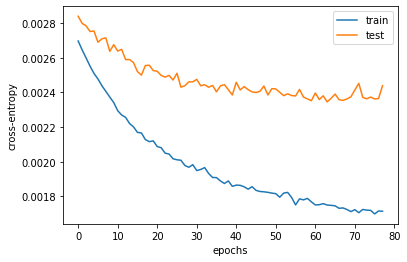

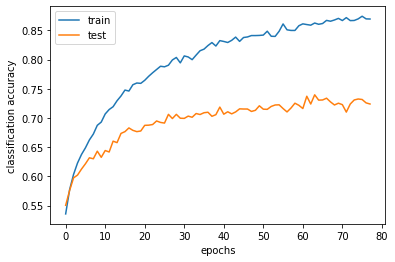

In [7]:
# YOUR CODE HERE
# plot learning curves
plt.figure(1)
plt.plot(range(len(train_loss_)), train_loss_, label='train')
plt.plot(range(len(test_loss_)), test_loss_, label = "test")
plt.xlabel('epochs')
plt.ylabel('cross-entropy')
plt.legend()

plt.figure(2)
plt.plot(range(len(train_acc_)), train_acc_, label='train')
plt.plot(range(len(test_acc_)), test_acc_, label='test')
plt.xlabel('epochs')
plt.ylabel('classification accuracy')
plt.legend()

2. Comment on line plots.

In [8]:
# YOUR CODE HERE
answer = "For Classification Accuracy against Epoch, we notice that training accuracy is increasing while test accuracy\
is plateauing. This suggest that the model is overfitting to the training data and is unable to generalise for the unseen\
test data. The model might be too complex with 3 hidden layers, each with 128 neurons, and is thus learning very intricate\
features in the training data. This can help the model to perform well in training, but it starts to fall off in testing.\
Similarly, for Loss against Epoch, we notice the same pattern whereby training loss continues to fall while test loss is\
plateauing. This can be explained with the same reasoning."